In [1]:
import os

os.environ["TPU_CHIPS_PER_HOST_BOUNDS"] = "1,1,1"
os.environ["TPU_HOST_BOUNDS"] = "1,1,1"
# Different per process:
os.environ["TPU_VISIBLE_DEVICES"] = "0"

# Hard EM - VAE: Fashion MNIST

In this notebook, we test the effectiveness and speed of hard-EM applied to a factor analysis and homoskedastic encoder.

We test this notebook considering an adam optimiser for both the VAE and the E and M steps of DLM hard EM.

# Fitting a distribution $q_n$ given $\boldsymbol\theta$

In this section, we find a variational distribution $q_n$ for $\boldsymbol\theta_\text{vae}$ and $\boldsymbol\theta_\text{hard-em}$. We consider a dataset ${\bf X}_\text{test}$ and train an unamortised variational distribution of the form

$$
    q_n(z_n) = \mathcal{N}(z_n \vert \mu_n, \sigma_n)
$$

In [2]:
import jax
import json
import glob
import tomli
import pickle
import flax.linen as nn
import numpy as np
import pandas as pd
import jax.numpy as jnp
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
%config InlineBackend.figure_format = "retina"

In [8]:
import sys
sys.path.append("../experiments/")
import base_vae_hardem

In [119]:
def build_iwmll_df(output):
    dict_mll_epochs = output["test"]
    df_all = []
    for key in dict_mll_epochs:
        df_mll = pd.DataFrame.from_dict(dict_mll_epochs[key])
        df_mll.columns = ["hard-em", "vae"]
        df_mll = pd.DataFrame.from_dict(dict_mll_epochs[key])
        df_mll.columns = [f"hard-em", "vae"]
        df_mll = df_mll.melt(value_name="mll")
        df_mll["episode"] = int(key.lstrip("e"))
        df_all.append(df_mll)
    df_all = pd.concat(df_all, axis=0)
    return df_all

## Load base configuration

In [5]:
path_config = "../experiments/configs/fmnistv01.toml"
with open(path_config, "rb") as f:
    config = tomli.load(f)

print(json.dumps(config, indent=2))

{
  "warmup": {
    "num_obs": 10000,
    "num_epochs": 1000,
    "batch_size": 200,
    "dim_latent": 50,
    "eval_epochs": [
      2,
      10,
      100,
      250,
      500,
      1000
    ],
    "learning_rate": 0.001,
    "vae": {
      "num_is_samples": 10
    },
    "hard_em": {
      "num_its_latent": 20,
      "num_its_params": 5
    }
  },
  "test": {
    "num_obs": 1000,
    "num_epochs": 1000,
    "learning_rate": 0.0001,
    "num_is_samples": 10
  }
}


In [15]:
class Decoder(nn.Module):
    """
    For the generative model
    p(x,z) = p(x|z) * p(z)
    """
    dim_full: int
    dim_latent: int = 20
    
    def setup(self):
        self.activation = nn.tanh
        self.mean = nn.Dense(self.dim_full, use_bias=True, name="mean")
        self.logvar = nn.Dense(self.dim_full, use_bias=False, name="logvar")
    
    @nn.compact
    def __call__(self, z):
        x = nn.Dense(100)(z)
        x = self.activation(x)
        x = nn.Dense(100)(x)
        x = self.activation(x)
        mean_x = self.mean(x)
        logvar_x = self.logvar(x)
        return mean_x, logvar_x 


class Encoder(nn.Module):
    """
    two-layered encoder
    """
    latent_dim: int
    n_hidden: int = 100
    
    @nn.compact
    def __call__(self, x):
        z = nn.Dense(self.n_hidden)(x)
        z = nn.relu(z)
        z = nn.Dense(self.n_hidden)(z)
        z = nn.relu(z)
        z = nn.Dense(self.n_hidden)(z)
        z = nn.relu(z)
        mean_z = nn.Dense(self.latent_dim)(z)
        logvar_z = nn.Dense(self.latent_dim)(z)
        return mean_z, logvar_z


In [16]:
dict_models = {
    "class_decoder": Decoder,
    "class_encoder": Encoder,   
    "class_encoder_test": hlax.models.GaussEncoder,
}

# Iteration - 01

In [17]:
output = base_vae_hardem.main(config, dict_models)

Warmup phase


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Test phase


  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

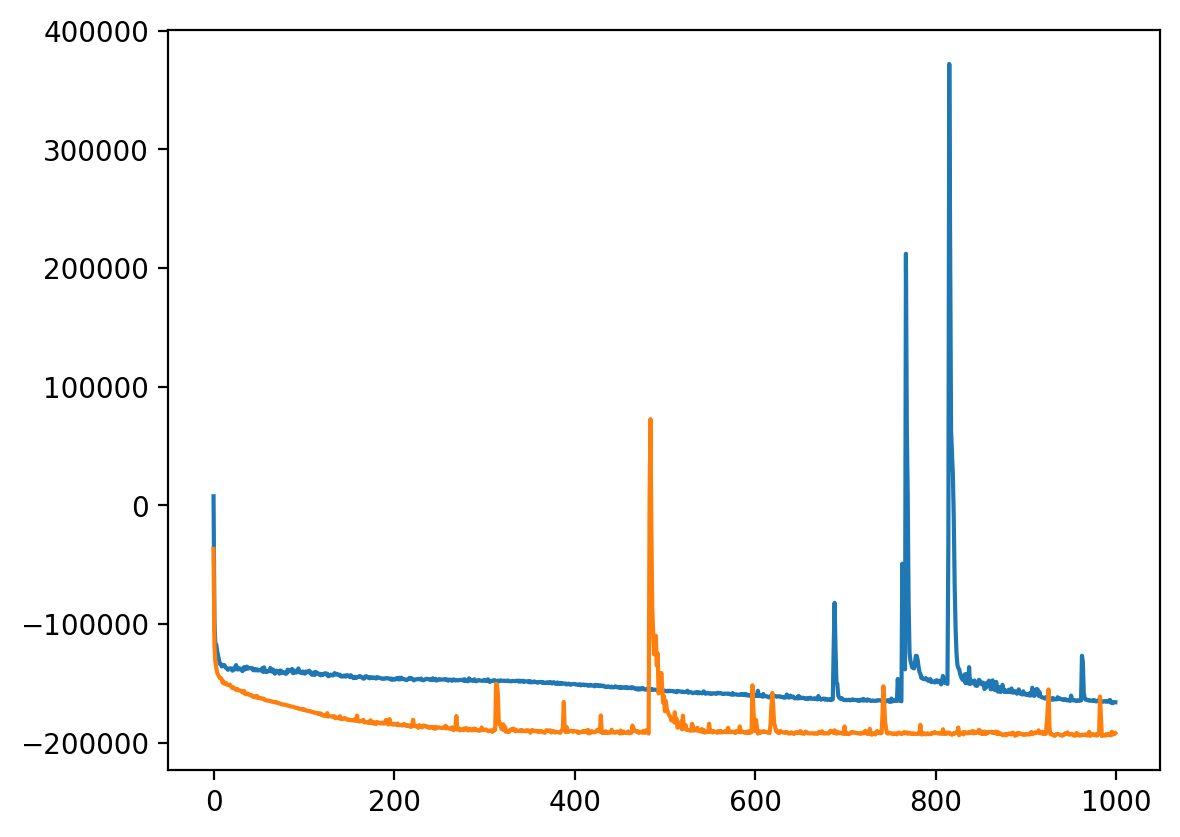

In [26]:
plt.plot(output["warmup"]["vae"]["hist_loss"])
plt.plot(output["warmup"]["hardem"]["hist_loss"])

### IWMLL

In [88]:
df_all = build_iwmll_df(output)

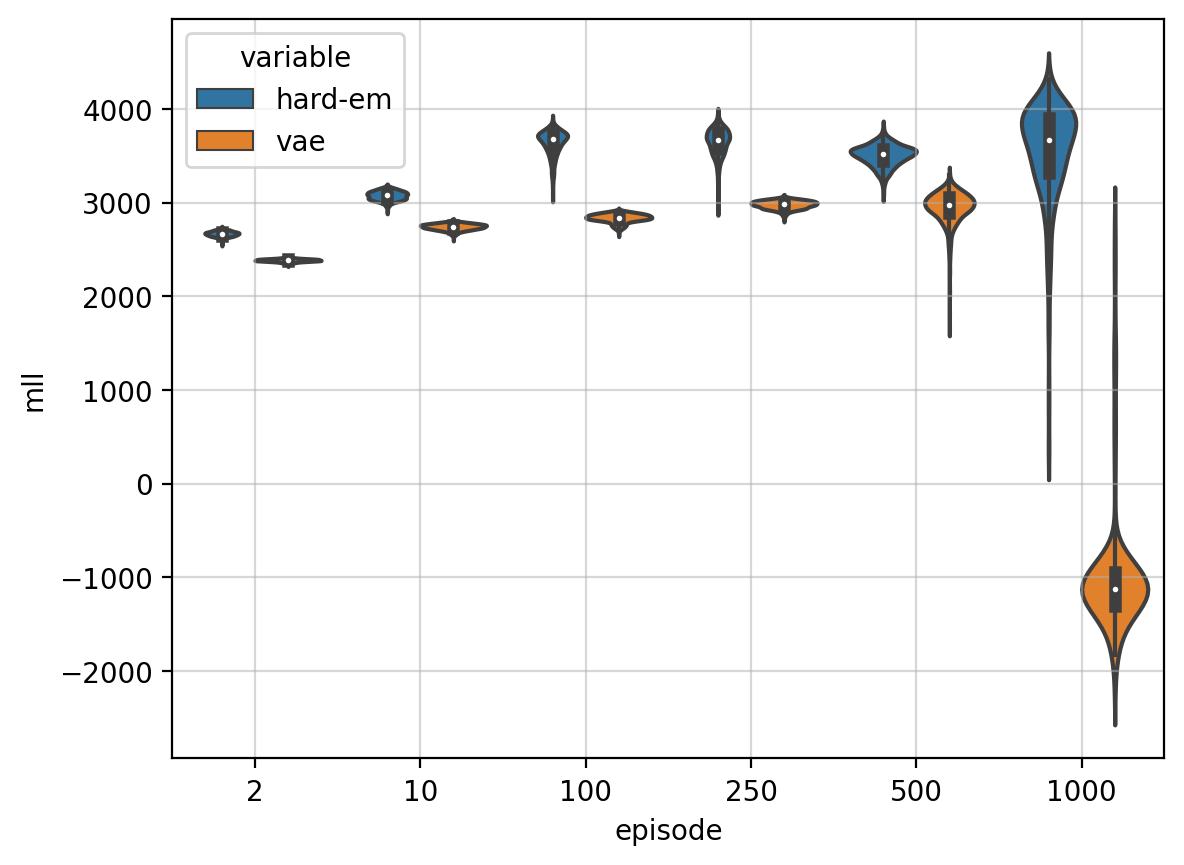

In [66]:
sns.violinplot(x="episode", y="mll", hue="variable", data=df_all)
plt.grid(alpha=0.5)

# Iteration - 02

In [76]:
config_mod = dict(config)
config_mod["warmup"]["learning_rate"] = 1e-4

In [77]:
output = base_vae_hardem.main(config_mod, dict_models)

Warmup phase


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Test phase


  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

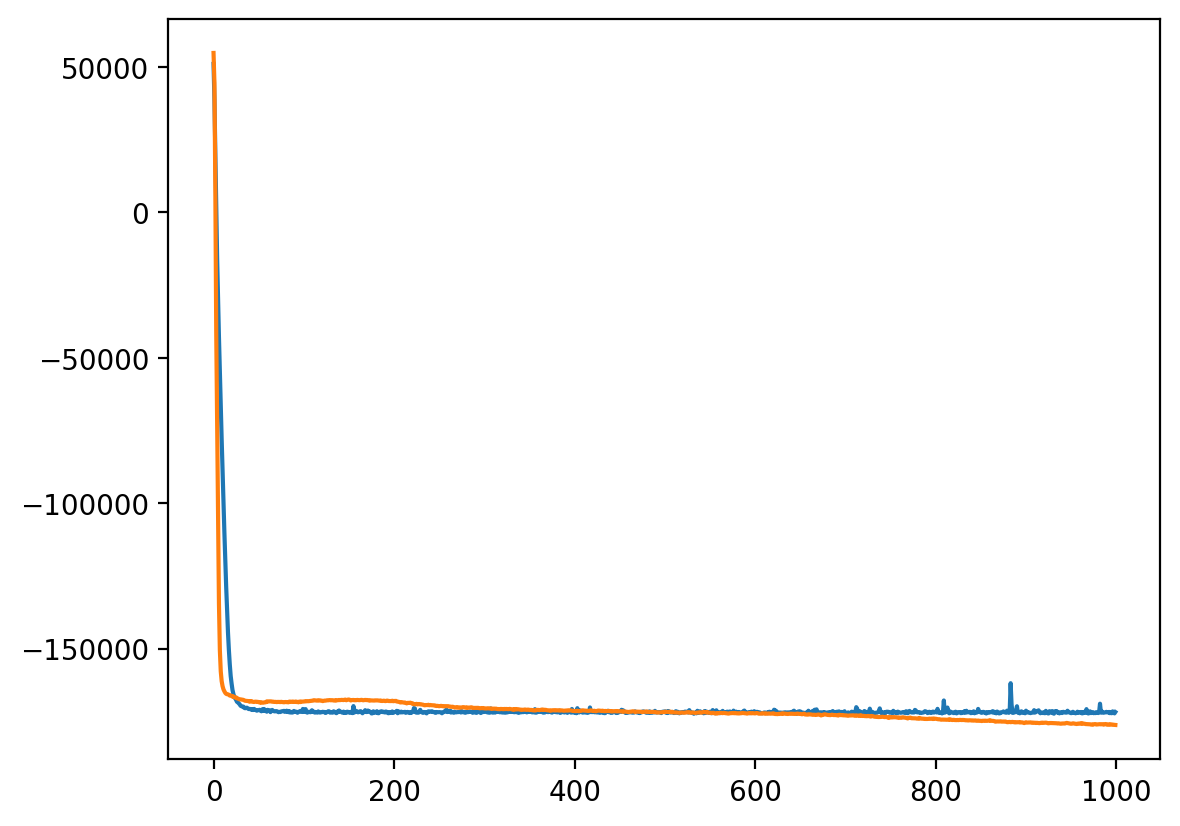

In [78]:
plt.plot(output["warmup"]["vae"]["hist_loss"])
plt.plot(output["warmup"]["hardem"]["hist_loss"])

### IWMLL

In [88]:
df_all = build_iwmll_df(output)

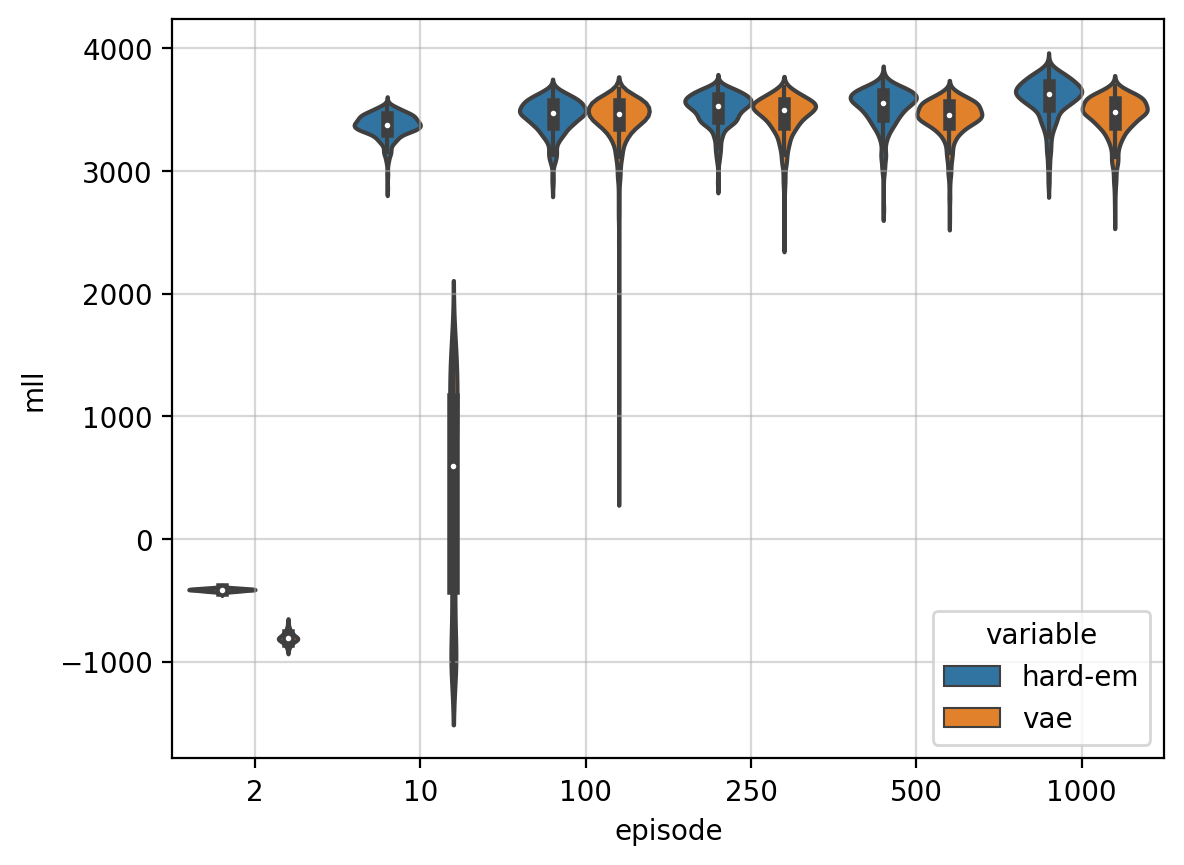

In [ ]:
sns.violinplot(x="episode", y="mll", hue="variable", data=df_all)
plt.grid(alpha=0.5)

# Iteration - 03

In [90]:
config_mod = dict(config)
config_mod["warmup"]["learning_rate"] = 1e-5

In [91]:
output = base_vae_hardem.main(config_mod, dict_models)

Warmup phase


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Test phase


  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

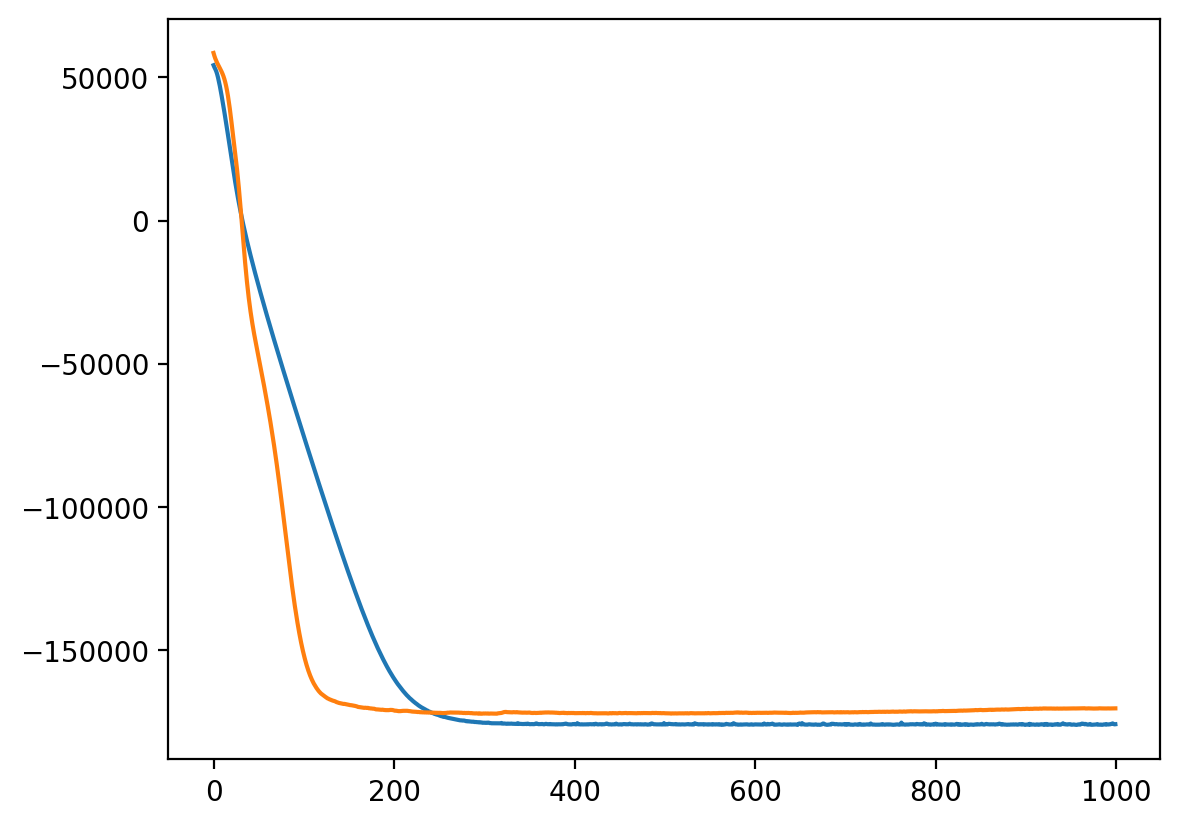

In [97]:
plt.plot(output["warmup"]["vae"]["hist_loss"])
plt.plot(output["warmup"]["hardem"]["hist_loss"])

### IWMLL

In [98]:
df_all = build_iwmll_df(output)

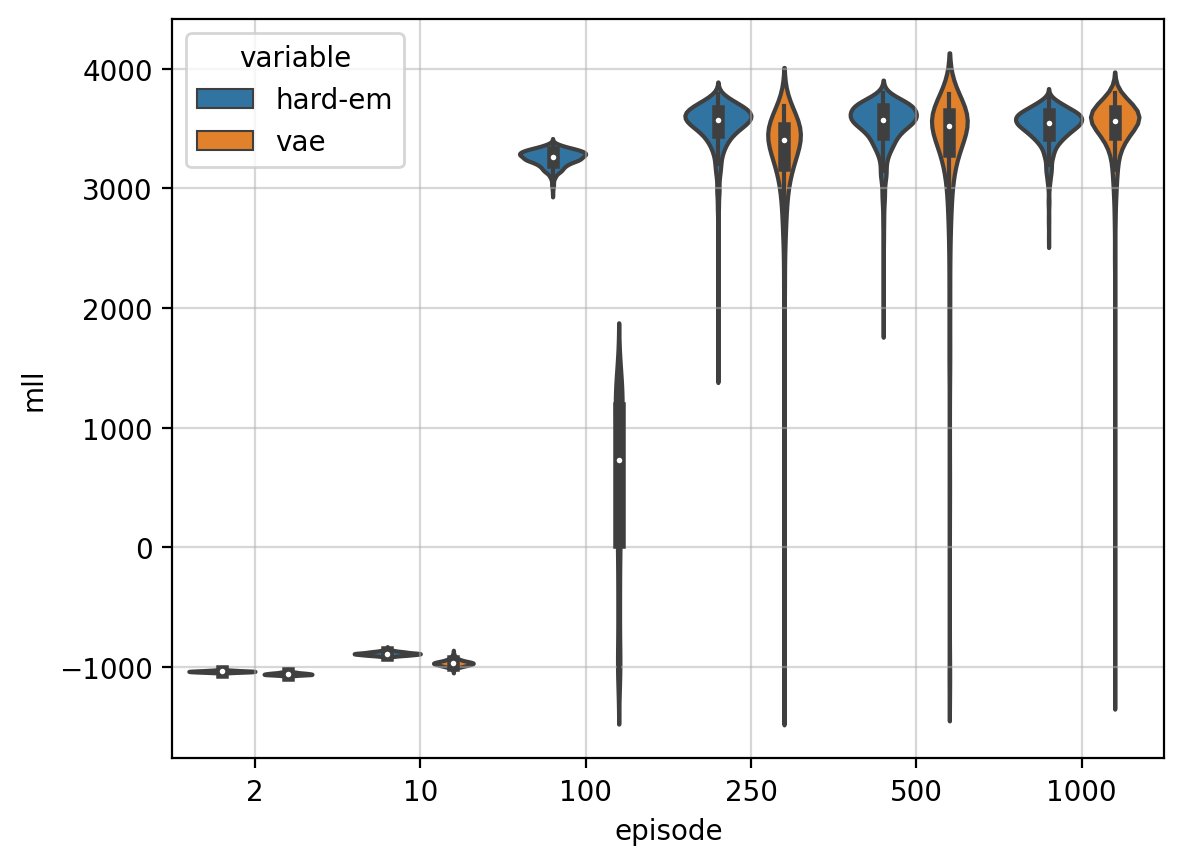

In [99]:
sns.violinplot(x="episode", y="mll", hue="variable", data=df_all)
plt.grid(alpha=0.5)

# Iteration - 04

In [105]:
config_mod = dict(config)
config_mod["warmup"]["num_epochs"] = 4000
config_mod["warmup"]["learning_rate"] = 1e-6
config_mod["warmup"]["eval_epochs"] = [2, 10, 100, 250, 500, 1000, 1250, 1500, 2000, 2250, 2500, 3000, 3250, 3500, 4000]

In [106]:
output = base_vae_hardem.main(config_mod, dict_models)

Warmup phase


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

Test phase


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

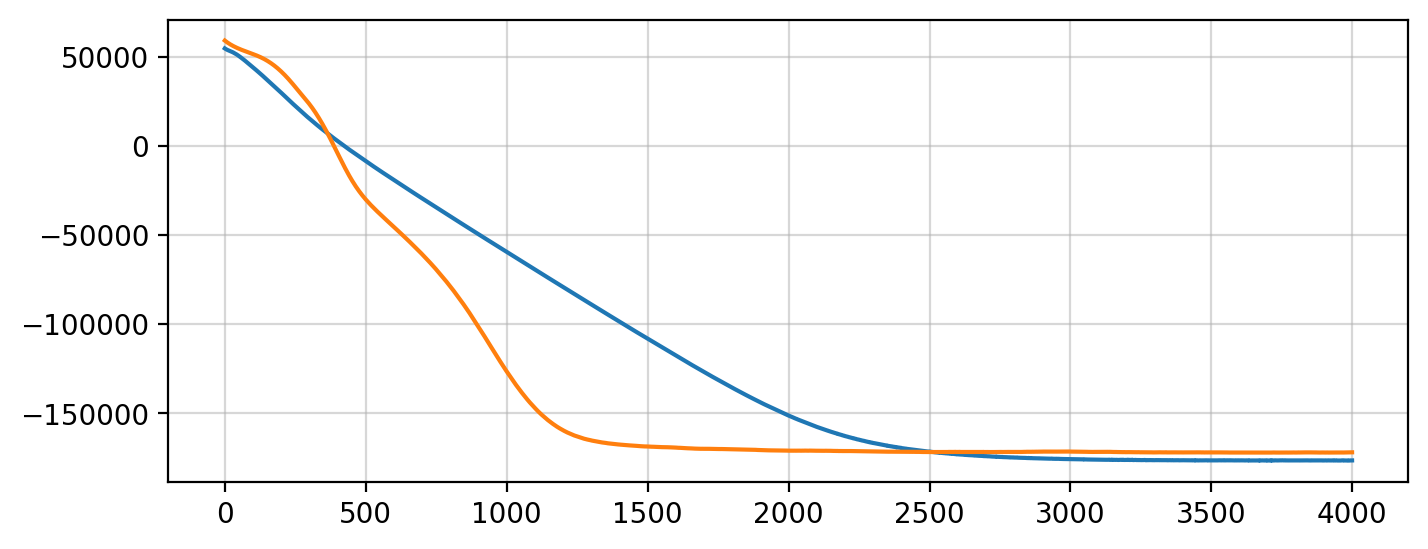

In [130]:
fig, ax = plt.subplots(figsize=(8, 3))
plt.plot(output["warmup"]["vae"]["hist_loss"])
plt.plot(output["warmup"]["hardem"]["hist_loss"])
ax.grid(alpha=0.5)

### IWMLL

In [120]:
df_all = build_iwmll_df(output)

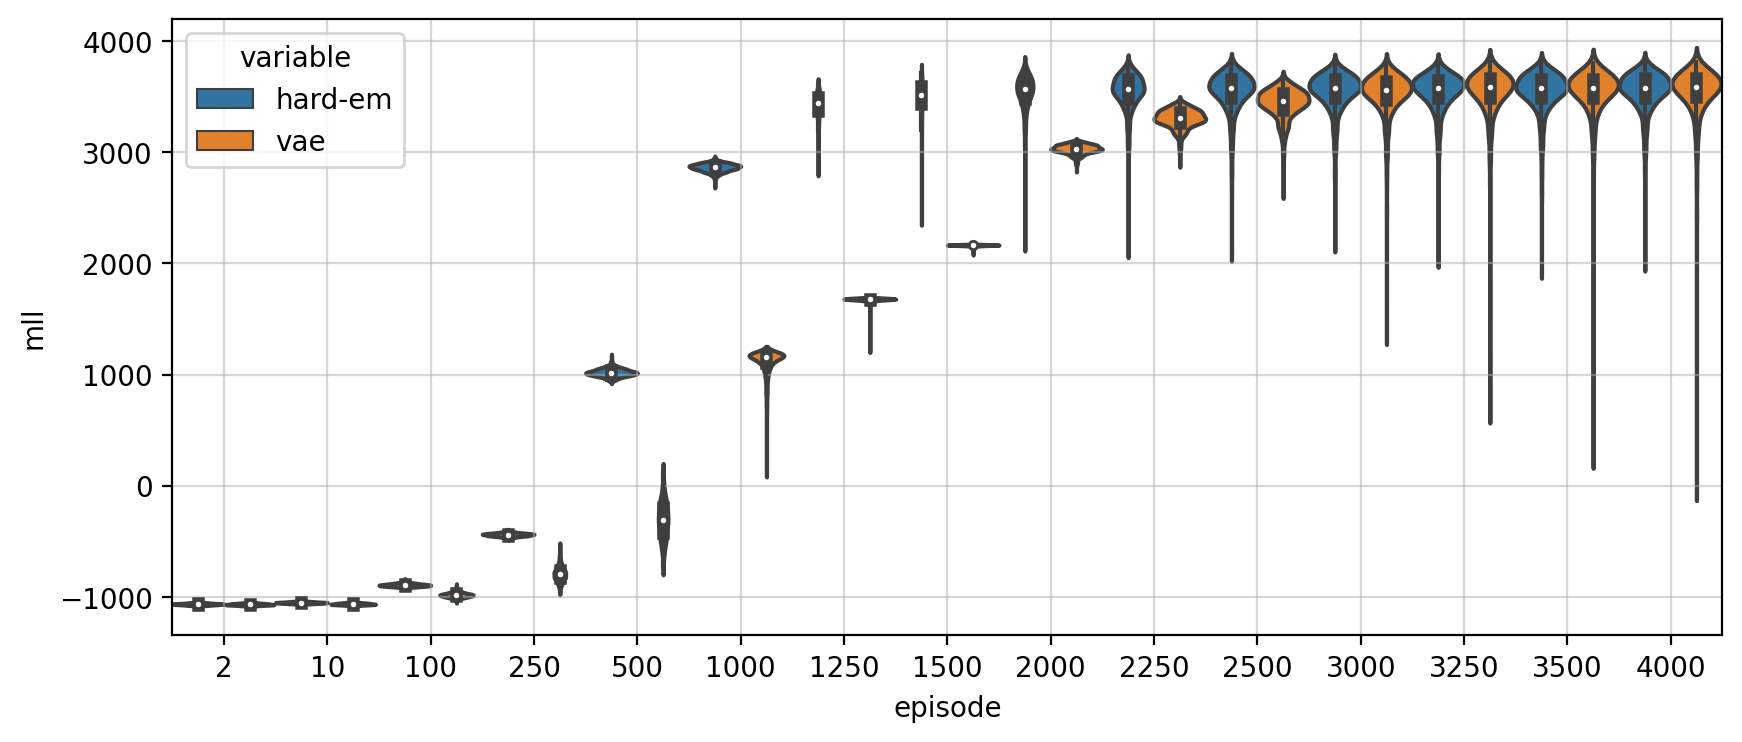

In [132]:
fig, ax = plt.subplots(figsize=(10, 4))
sns.violinplot(x="episode", y="mll", hue="variable", data=df_all, ax=ax, width=1.0)
plt.grid(alpha=0.5)

# Number of iterations